# BoXYZ - Depth Map Processing

Here I process the depth map to create a 3D point cloud and visualize it using Open3D


In [ ]:
!pip install --quiet numpy matplotlib open3d

In [1]:
import os
import copy 

import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from utils.camera_params_open3d import get_camera_parameters_interactive

INTERACTIVE_VISUALIZATION = 'INTERACTIVE_VISUALIZATION' in os.environ
BBOX_COLORS = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [1, 1, 0],
    [1, 0, 1],
    [0, 1, 1],
    [0.5, 0.5, 0.5],
    [1, 0.5, 0],
]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# get pcb from depth map
intrinsics_filename = os.path.join('..', 'assets', 'intrinsics.npy')
K = np.load(intrinsics_filename)

depth_filename = os.path.join('..', 'assets', 'one-box.depth.npdata.npy')
xyz = np.load(depth_filename)
print('Depth map shape', xyz.shape)

h, w = xyz.shape
v, u = np.mgrid[0:h, 0:w]
u = u.flatten()
v = v.flatten()
z = xyz.flatten()
valid = z > 0
u = u[valid]
v = v[valid]
z = z[valid]
fx, fy = K[0, 0], K[1, 1]
cx, cy = K[0, 2], K[1, 2]
x = (u - cx) * z / fx
y = (v - cy) * z / fy
xyz = np.column_stack([x, y, z])
        
pcb = o3d.geometry.PointCloud()
pcb.points = o3d.utility.Vector3dVector(xyz)

extrinsics_filename = os.path.join('..', 'assets', 'extrinsics.npy')
extrinsic_matrix = np.load(extrinsics_filename)

# TODO (fabawi): check if is this right. Is it in m instead of mm? Looks wrong but not important anyway
extrinsic_matrix_meters = extrinsic_matrix.copy()
extrinsic_matrix_meters[:3, 3] = extrinsic_matrix_meters[:3, 3] / 1000.0
camera_world_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.3, origin=[0, 0, 0])
camera_to_world = np.linalg.inv(extrinsic_matrix_meters)
camera_world_frame.transform(camera_to_world)

Depth map shape (1544, 2064)


TriangleMesh with 1134 points and 2240 triangles.

In [3]:
# add colors to pcb
color_filename = os.path.join('..', 'assets', 'one-box.color.npdata.npy')
pcb_col = np.load(color_filename)
print('Color data shape', pcb_col.shape)

colors = pcb_col.reshape(-1, 3)
colors = colors / 255.0
pcb.colors = o3d.utility.Vector3dVector(colors)

Color data shape (1544, 2064)


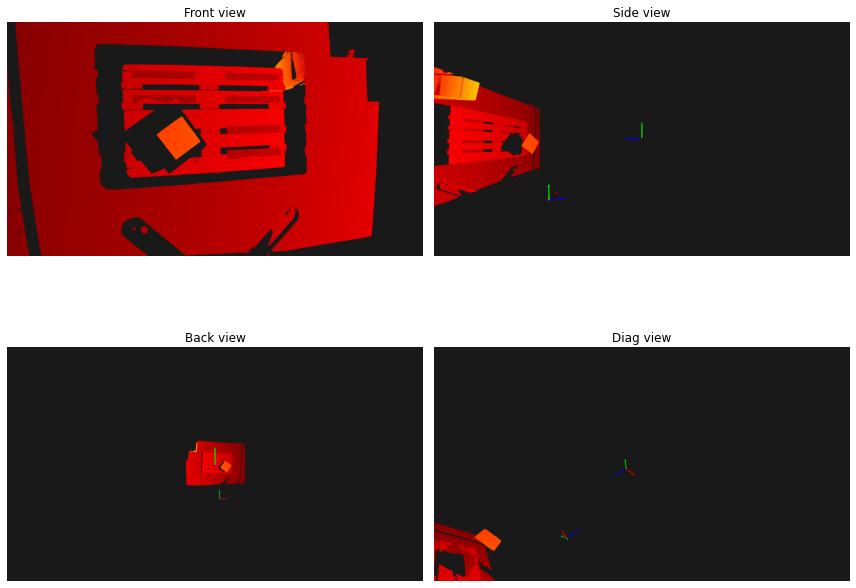

In [4]:
# visualize the pcb in notebook
def capture_pcb_snapshots(pcb):
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name='Point Cloud Visualization', visible=False)
    vis.add_geometry(pcb)
    
    camera_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.3, origin=[0, 0, 0])
    vis.add_geometry(camera_frame)
    vis.add_geometry(camera_world_frame)
    opt = vis.get_render_option()
    opt.background_color = np.array([0.1, 0.1, 0.1])
    opt.point_size = 2.0
    
    snapshots = []
    view_names = ["Front view", "Side view", "Back view", "Diag view"]
    
    ctr = vis.get_view_control()
    ctr.change_field_of_view(step=60)
    vis.poll_events()
    vis.update_renderer()
    img = vis.capture_screen_float_buffer(do_render=True)
    snapshots.append(np.asarray(img))
    
    view_angles = [
        (0, np.pi/2, 0),
        (0, np.pi, 0),
        (np.pi/4, np.pi/4, 0)
    ]
    
    view_translations = [
        [0, 0, 0],
        [0, 0, 0],
        [0.5, 0.5, 0]
    ]
        
    for i, ((pitch, yaw, roll), translation) in enumerate(zip(view_angles, view_translations)):
        ctr = vis.get_view_control()
        ctr.change_field_of_view(step=60)
        ctr.set_front([np.sin(yaw) * np.cos(pitch), np.sin(pitch), np.cos(yaw) * np.cos(pitch)])
        ctr.set_lookat([0 + translation[0], 0 + translation[1], 0 + translation[2]])
        ctr.set_up([0, 1, 0])
        vis.poll_events()
        vis.update_renderer()
        img = vis.capture_screen_float_buffer(do_render=True)
        snapshots.append(np.asarray(img))
        
    vis.destroy_window()
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for i, (img, view_name) in enumerate(zip(snapshots, view_names)):
        axes[i].imshow(img)
        axes[i].set_title(f'{view_name}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# visualize pcb in interactive window
def visualize_pcb_interactive(pcb):
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name='Point Cloud Visualization')
    vis.add_geometry(pcb)
    
    camera_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.3, origin=[0, 0, 0])
    vis.add_geometry(camera_frame)
    vis.add_geometry(camera_world_frame)
    opt = vis.get_render_option()
    opt.background_color = np.array([0.1, 0.1, 0.1])
    opt.point_size = 2.0
    
    vis.run()
    vis.destroy_window()

def generate_3d_scene(pcb, visualize=False):
    o3d.io.write_point_cloud(os.path.join('..', 'assets', 'one-box.pcb.ply'), pcb)
    if visualize:
        visualize_pcb_interactive(pcb)
    capture_pcb_snapshots(pcb)
    
generate_3d_scene(pcb, visualize=INTERACTIVE_VISUALIZATION)

In [5]:
# get custom view angle and get params of virtual camera
#virtual_camera_params = get_camera_parameters_interactive(pcb)

## Detect Carton Box Poses

I removed the outliers points in the point cloud to avoid clustering anomolies into the 3D bounding boxes and downsamples the points for efficiency. The RANSAC and outlier properties were set based on trial and error which might not work for other depth maps, but I would need more samples to adjust accordingly (or use an ML-based approach to segment the cartons, like [RandLANet in Open3D ML](https://github.com/isl-org/Open3D-ML?tab=readme-ov-file#running-a-pretrained-model-for-semantic-segmentation) but that goes beyond the task's requirements).

The plane is segmented to detect flat surfaces like the floor, pallet, and even the carton box itself. Next, the planes are clustered with DBSCAN, setting the minimum points to 200 (imperically found that that number of points seems to work for the box, but might break for smaller boxes). The clusters are sorted by size, with the largest covering the entire cloud space, the second-largest being the pallet, and finally the carton box. I extend the base of the carton box's bounding box (third-largest object) towards the top of the pallet surface (second-largest object). 

Cluster 0 - Box center: [-0.09728322  0.01589678  2.5504915 ]
Cluster 0 - Box dimensions: [2.49587647 1.84502984 0.75260384]
Cluster 1 - Box center: [-0.07539183  0.08364886  2.6891863 ]
Cluster 1 - Box dimensions: [1.32198518 0.94868747 0.15492836]
Cluster 2 - Box center: [-0.41326479 -0.09928235  2.47919068]
Cluster 2 - Box dimensions: [0.31139237 0.31756038 0.28457371]


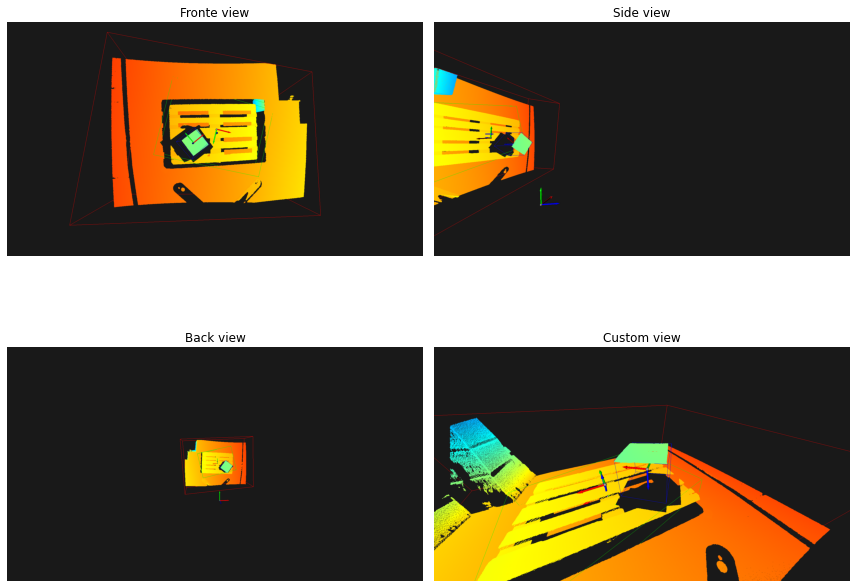

In [6]:
# check if box is above pallet
def extend_bbox_to_pallet(pallet_top, obb):
    obb_bottom = obb.center[2] + obb.extent[2]/2 
    if obb_bottom > pallet_top:
        return obb.center[2], obb.extent[2]
    else:
        obb_center_z = obb.center[2] + obb.extent[2]/2 + (pallet_top - obb_bottom)/2
        obb_extent_z = pallet_top - (obb.center[2] - obb.extent[2]/2)
    return obb_center_z, obb_extent_z


# visualize pcb with bboxes in interactive window
def visualize_box_detection(pcb, boxes, box_clouds):
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name='Box Detection')
    vis.add_geometry(pcb)
    
    for i, (obb, cloud) in enumerate(zip(boxes, box_clouds)):
        vis.add_geometry(obb)
        
        center = obb.get_center()
        R = obb.R
        extent = obb.extent
        
        print(f"Cluster {i} - Box center: {center}")
        print(f"Cluster {i} - Box dimensions: {extent}")
        
        box_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2, origin=center)
        box_frame.rotate(R, center=center)
        vis.add_geometry(box_frame)
        vis.add_geometry(camera_world_frame)

    opt = vis.get_render_option()
    opt.background_color = np.array([0.1, 0.1, 0.1])
    opt.point_size = 2.0
    
    vis.run()
    vis.destroy_window()

# visualize the bboxes in the notebook
def capture_box_detection_snapshots(pcb, boxes):
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name='Box Detection Snapshots', visible=False)
    vis.add_geometry(pcb)
    
    for i, obb in enumerate(boxes):
        vis.add_geometry(obb)
        
        box_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2, origin=obb.get_center())
        box_frame.rotate(obb.R, center=obb.get_center())
        vis.add_geometry(box_frame)
        vis.add_geometry(camera_world_frame)
    
    opt = vis.get_render_option()
    opt.background_color = np.array([0.1, 0.1, 0.1])
    opt.point_size = 2.0
    
    snapshots = []
    view_names = ["Fronte view", "Side view", "Back view", "Custom view"]
    
    ctr = vis.get_view_control()
    ctr.change_field_of_view(step=60)
    vis.poll_events()
    vis.update_renderer()
    img = vis.capture_screen_float_buffer(do_render=True)
    snapshots.append(np.asarray(img))
    
    view_angles = [
        (0, np.pi/2, 0),
        (0, np.pi, 0),
        (0, 0, 0)
    ]
    
    view_translations = [
        [0, 0, 0],
        [0, 0, 0],
        [0.5, 0.3, 0.3]
    ]
    
    for i, ((pitch, yaw, roll), translation) in enumerate(zip(view_angles, view_translations)):
        ctr = vis.get_view_control()
        ctr.change_field_of_view(step=60)
        
        if i == 2:  # custom view
            camera_params = o3d.camera.PinholeCameraParameters()
            camera_params.extrinsic = np.array([
                [-0.89818829, -0.40778351, 0.16422669, -0.7810453],
                [0.34819119, -0.43184673, 0.83202842, -1.92402076],
                [-0.26836671, 0.80450047, 0.52986631, -0.49629674],
                [0., 0., 0., 1.]
            ])
            camera_params.intrinsic = vis.get_view_control().convert_to_pinhole_camera_parameters().intrinsic
            
            ctr.convert_from_pinhole_camera_parameters(camera_params)
        else:
            ctr.set_front([np.sin(yaw) * np.cos(pitch), np.sin(pitch), np.cos(yaw) * np.cos(pitch)])
            ctr.set_lookat([0 + translation[0], 0 + translation[1], 0 + translation[2]])
            ctr.set_up([0, 1, 0])
        
        vis.poll_events()
        vis.update_renderer()
        img = vis.capture_screen_float_buffer(do_render=True)
        snapshots.append(np.asarray(img))
        
    vis.destroy_window()
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for i, (img, view_name) in enumerate(zip(snapshots, view_names)):
        axes[i].imshow(img)
        axes[i].set_title(f'{view_name}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# detect the bboxes (with poses)
def detect_box_pose(pcb, visualize=False):
    pcd_downsampled = pcb.voxel_down_sample(voxel_size=0.01)
    
    # TODO (fabawi): outlier removal of points, but does not deal with artefacts like the corner of the pallet. 
    #                Maybe it can be shape-based filtering? But are all cartons cuboids? Maybe irregular shapes
    #                can be expected? Leave it for now
    pcd_cleaned, _ = pcd_downsampled.remove_statistical_outlier(nb_neighbors=20, std_ratio=0.001)
    
    plane_model, inliers = pcd_cleaned.segment_plane(distance_threshold=0.03,
                                                         ransac_n=4,
                                                         num_iterations=1000)
    
    planes = pcd_downsampled.select_by_index(inliers, invert=True)
    
    labels = np.array(planes.cluster_dbscan(eps=0.12, min_points=200))
    
    if len(np.unique(labels[labels >= 0])) == 0:
        return None, None
    
    cluster_sizes = [(labels == i).sum() for i in range(max(labels) + 1)]
    sorted_cluster_sizes = np.argsort(cluster_sizes)[::-1]
    
    boxes = []
    box_clouds = []
    
    pallet_obb_top = None
    
    for i, cluster_idx in enumerate(sorted_cluster_sizes):
        cluster_cloud = planes.select_by_index(np.where(labels == cluster_idx)[0])
        obb = cluster_cloud.get_oriented_bounding_box()
        if i == 1:
            pallet_obb_top = obb.center[2] - obb.extent[2]/2 
        elif pallet_obb_top:
            obb_center_z, obb_extent_z = extend_bbox_to_pallet(pallet_obb_top, obb)
            new_extent = np.array([obb.extent[0], obb.extent[1], obb_extent_z])
            new_center = np.array([obb.center[0], obb.center[1], obb_center_z])
            obb = o3d.geometry.OrientedBoundingBox(new_center, obb.R, new_extent)
                
        
        obb.color = BBOX_COLORS[i % len(BBOX_COLORS)]
        boxes.append(obb)
        box_clouds.append(cluster_cloud)
    
    if visualize and boxes:
        visualize_box_detection(pcb, boxes, box_clouds)
    
    capture_box_detection_snapshots(pcb, boxes)
    return boxes, box_clouds

box_pose, box_points = detect_box_pose(pcb, visualize=INTERACTIVE_VISUALIZATION)

## Camera to Object Frame

I used the extrinsic matrix to calculate the camera-to-object transformations. The carton box is the third-largest object in the scene, and its 4x4 transformation matrix is printed below. The carton box mesh is shown relative to the camera. 

In [7]:
# get transformation matrices (camera to object)
camera_to_world = extrinsic_matrix
box_poses_camera_to_object = []

for i, obb in enumerate(box_pose):
    object_in_camera = np.eye(4)
    object_in_camera[:3, :3] = obb.R
    object_in_camera[:3, 3] = obb.center
    
    object_in_world = camera_to_world @ object_in_camera
    camera_to_object = np.linalg.inv(camera_to_world) @ object_in_world
    
    box_poses_camera_to_object.append(camera_to_object)
    
    print(f"Box {i} transformation matrix (camera to object):")
    if i == 2:
        print("\n<------------------------- This is the carton box ----------------------->\n")
    print(camera_to_object)
    if i == 2:
        print("<-------------------------xxxxxxxxxxxxxxxxxxxxxxx ----------------------->")
    
    print()
    

Box 0 transformation matrix (camera to object):
[[ 0.98434713  0.05157011  0.16852673 -0.09728322]
 [-0.07215303  0.99034247  0.11838806  0.01589678]
 [-0.16079389 -0.12869466  0.9785617   2.5504915 ]
 [ 0.          0.          0.          1.        ]]

Box 1 transformation matrix (camera to object):
[[ 9.67417103e-01 -2.27895847e-01 -1.10306991e-01 -7.53918342e-02]
 [-2.29271778e-01 -9.73362422e-01  2.15892432e-04  8.36488553e-02]
 [-1.07417880e-01  2.50814218e-02 -9.93897541e-01  2.68918630e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Box 2 transformation matrix (camera to object):

<------------------------- This is the carton box ----------------------->

[[ 0.76130147 -0.63856618  0.11248696 -0.41326479]
 [ 0.64384248  0.7650186  -0.01460813 -0.09928235]
 [-0.07672636  0.08354507  0.99354581  2.47919068]
 [ 0.          0.          0.          1.        ]]
<-------------------------xxxxxxxxxxxxxxxxxxxxxxx ----------------------->



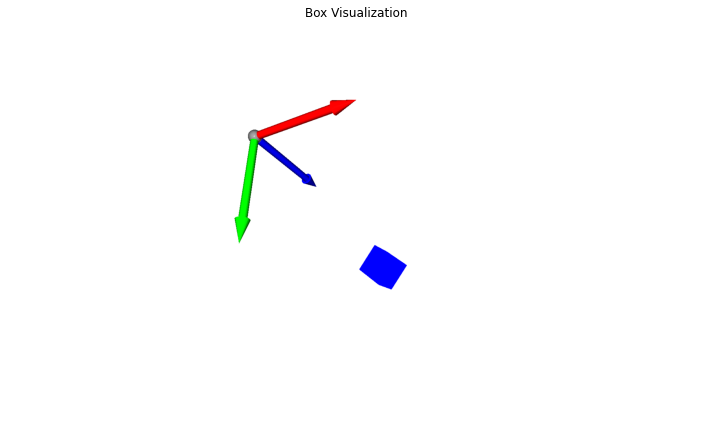

In [8]:
# create meshes for carton boxes
def create_box_mesh(idx, box_pose):
    width=box_pose[idx].extent[0]
    height=box_pose[idx].extent[1]
    depth=box_pose[idx].extent[2]
    box = o3d.geometry.TriangleMesh.create_box(width=width, 
                                               height=height, 
                                               depth=depth)
    box.translate([-width/2, -height/2, -depth/2])
    return box

# visualize the boxes as meshes in interactive window
def visualize_boxes(box_poses):
    # Create visualizer
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    
    for i, pose_matrix in enumerate(box_poses):
        if i > 1:
            box = create_box_mesh(i, box_pose)
            box.paint_uniform_color(BBOX_COLORS[i % len(BBOX_COLORS)])
            box.transform(pose_matrix)
            vis.add_geometry(box)
    
    coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
    vis.add_geometry(coord_frame)
    
    view_control = vis.get_view_control()
    view_control.set_front([0.5, 0.5, -1])
    view_control.set_up([0, -1, 0])
    view_control.set_lookat([0, 0, 1])
    view_control.set_zoom(0.5)
    
    vis.run()
    vis.destroy_window()
    
# visualize the bbox meshes in the notebook
def capture_box_mesh_screenshot(box_poses):
    # Create visualizer
    vis = o3d.visualization.Visualizer()
    vis.create_window(visible=False)
    
    for i, pose_matrix in enumerate(box_poses):
        if i > 1:
            box = create_box_mesh(i, box_pose)
            box.paint_uniform_color(BBOX_COLORS[i % len(BBOX_COLORS)])
            box.transform(pose_matrix)
            vis.add_geometry(box)
    
    coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
    vis.add_geometry(coord_frame)
    
    view_control = vis.get_view_control()
    view_control.set_front([0.5, 0.5, -1])
    view_control.set_up([0, -1, 0])
    view_control.set_lookat([0, 0, 1])
    view_control.set_zoom(0.5)
    
    vis.poll_events()
    vis.update_renderer()
    img = vis.capture_screen_float_buffer(do_render=True)
    vis.destroy_window()
    
    plt.figure(figsize=(10, 8))
    plt.imshow(np.asarray(img))
    plt.axis('off')
    plt.title('Box Visualization')
    plt.tight_layout()
    plt.show()
    

if INTERACTIVE_VISUALIZATION:
    visualize_boxes(box_poses_camera_to_object)
capture_box_mesh_screenshot(box_poses_camera_to_object)